# Introduction

This is a notebook to see if there is an impact of the socio-demographic variables on the tendency for the subject to get `Right` or `Wrong`. 
It also serves as a recoding and cleaning notebook to obtain a clean dataset that can be reused for other analysis in the future. 


## Import modules and functions

### Modules

In [1]:
# Import modules
import json
import csv
import math

import itertools 
from itertools import combinations

# Classic analysis imports
import numpy as np 
import pandas as pd 
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

# Stat analysis import 
from sklearn import preprocessing
from sklearn.cluster import KMeans


import scipy 
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests

import scikit_posthocs as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.stattools as stools

import statsmodels.stats as stats 

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.anova import anova_lm

from statsmodels.stats import multicomp as mc
from statsmodels.miscmodels.ordinal_model import OrderedModel

from pymer4.models import Lmer

import pingouin as pg

# options for the notebook
pd.set_option('display.max_colwidth',1000)
plt.style.use('seaborn')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5, 5]

### Functions

In [2]:
# Source: https://github.com/neuhofmo/chisq_test_wrapper


# This module contains functions that wrap the standard chi2_contingency test from scipy.stats.,
# as well as additional corrections for multiple comparisons and post-hoc tests.
# The usage is as simple as chisq_and_posthoc_corrected(df) 

# Uploaded by Moran Neuhof, 2018


def get_asterisks_for_pval(p_val, alpha=0.05):
    """Receives the p-value and returns asterisks string."""
    if p_val > alpha:  # bigger than alpha
        p_text = "ns"
    # following the standards in biological publications
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text  # string of asterisks


def run_chisq_on_combination(df, combinations_tuple):
    """Receives a dataframe and a combinations tuple and returns p-value after performing chisq test."""
    assert len(combinations_tuple) == 2, "Combinations tuple is too long! Should be of size 2."
    new_df = df[(df.index == combinations_tuple[0]) | (df.index == combinations_tuple[1])]
    chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
    return p


def chisq_and_posthoc_corrected(df, correction_method='fdr_bh', alpha=0.05):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction).
    alpha: optional threshold for rejection (default: 0.05)
    correction_method: method used for mutiple comparisons correction. (default: 'fdr_bh').
    See statsmodels.sandbox.stats.multicomp.multipletests for elaboration."""

    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chi2, p))
    
    # post-hoc test
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    print("Post-hoc chi2 tests results:")
    p_vals = [run_chisq_on_combination(df, comb) for comb in all_combinations]  # a list of all p-values
    # the list is in the same order of all_combinations

    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method=correction_method, alpha=alpha)[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print("{}: p_value: {:5f}; corrected: {:5f} ({}) reject: {}".format(comb, p_val, corr_p_val, get_asterisks_for_pval(p_val, alpha), reject))
    return chi2, p, dof, ex


In [3]:
from scipy.stats import chi2_contingency
from scipy.stats import norm
def chisq_posthoc_corrected(cross_table, correction_method='bonferroni', alpha=.05):
    """
    Get crosstab dataframe and do a chisquared test followed with the post-hoc with analysis of adjusted residuals
    source: https://colab.research.google.com/drive/1QIDHMvpDq7Max5hk2mozSFdVssavdV-I#scrollTo=ig1kdg40qLDH
    source: https://github.com/neuhofmo/chisq_test_wrapper
    """
    def get_asterisks_for_pval(p_val, alpha=0.05):
        """Receives the p-value and returns asterisks string."""
        if p_val > alpha:  # bigger than alpha
            p_text = "ns"
        # following the standards in biological publications
        elif p_val < 1e-4:  
            p_text = '****'
        elif p_val < 1e-3:
            p_text = '***'
        elif p_val < 1e-2:
            p_text = '**'
        else:
            p_text = '*'
    
        return p_text  # string of asterisks
    
    chiVal, pVal, df, exp = chi2_contingency(cross_table)
    print("Chi2 result of the contingency table: {}, p-value: {}\n".format(chiVal, pVal))

    colTotals = cross_table.sum()
    nCols = len(colTotals)
    rowTotals = cross_table.sum(axis=1)
    nRows = len(rowTotals)
    n = sum(rowTotals)
    
    
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5            
    phRes = pd.DataFrame(columns=[cross_table.index.name, cross_table.columns.name, 'Adj. Res.'])
    for i in range(nRows):
        for j in range(nCols):
            AdjRes = (cross_table.iloc[i,j] - exp[i,j]) / (exp[i,j]*(1-rowTotals[i]/n)*(1-colTotals[j]/n))**0.5
            phRes = phRes.append({cross_table.index.name:cross_table.index[i], cross_table.columns.name:cross_table.columns[j], 'Adj. Res.':AdjRes}, ignore_index=True)
    phRes['p_value'] = 2*(1-norm.cdf(abs(phRes['Adj. Res.'])))
    # Bonferroni correction
  
    reject_list, corrected_p_vals = multipletests(phRes['p_value'], method=correction_method, alpha=alpha)[:2]
    
    phRes['p_value_corrected'] = corrected_p_vals
    phRes['reject'] = reject_list
    ast = []
    for p_vals in corrected_p_vals:
        ast.append(get_asterisks_for_pval(p_vals))
    phRes['asterisques'] = ast

    return phRes


# Data

## Loading

In [4]:
# Setting up the folders 
data_folder = "../data/"
analysis_results_folder = "../results/"
plots_folders = "../plots"

# Filenames
dataset_clean_filename = 'cleaned_dataset_per_subject.csv'

dataset_news_full_filename = 'cleaned_dataset_per_news.csv'

In [5]:
df = pd.read_csv('{}{}'.format(data_folder, dataset_clean_filename))
df.head()

,fake_news,true_news,first_true,reread_fake,reread_true,date_arrive,date_finish,state,time,id_sondea,...,r_w,dm_pref_religion,recode_religion,recode_politics,recode_age,dm_education,recode_education,recode_education2,total_checked_f,total_checked_t
0,Stefano Montario: las mascarillas incuban el cáncer,Una vacuna contra la poliomielitis podría ser la solución contra el coronavirus,True,False,False,2021-03-17 14:04:13.103024+00:00,2021-03-17 14:10:39.487599+00:00,result,6.43,610,...,W,Agnóstico,No religious,Izquierda,>55,Secundaria,No_university_studies,up_to_secondaria,1,1
1,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Coronavirus: llega a Madrid el material sanitario al que Huawei se comprometió con el rey Felipe VI,True,False,False,2021-03-15 20:16:10.657700+00:00,2021-03-15 20:18:37.196160+00:00,result,2.45,2006,...,W,Católico,Religious,Izquierda,>55,Secundaria,No_university_studies,up_to_secondaria,1,1
2,Hantavirus. La OMS advierte al mundo del nuevo virus que viene de China,Utilizar guantes no tiene ningún sentido,False,True,True,2021-03-17 12:49:33.008115+00:00,2021-03-17 13:14:09.004934+00:00,result,43.65,2266,...,W,Agnóstico,No religious,NaN,>55,Grado/Licenciatura,University_studies,up_to_university_level,1,1
3,Demuestran científicamente la relación causal entre la tecnologia 5G y el COVID-19,Coronavirus | No hay evidencia de que los perros transmitan el virus,False,False,False,2021-03-16 16:44:06.670711+00:00,2021-03-16 16:49:18.354946+00:00,result,5.20,2331,...,W,Ateo,No religious,Centro,35-54,Master,University_studies,up_to_university_level,1,1
4,"La OMS alerta sobre el Virus Nipah, que puede ser peor que el Covid-19",Moscú vigilará la cuarentena mediante un código QR,False,True,False,2021-03-16 14:30:01.034250+00:00,2021-03-16 14:46:49.878175+00:00,result,25.03,2548,...,R,Agnóstico,No religious,NaN,>55,Doctorado,University_studies,up_to_university_level,1,1


In [6]:
df_news = pd.read_csv('{}{}'.format(data_folder, dataset_news_full_filename))
df_news['id_sondea'] = df_news['id_sondea'].astype(str)

# Analysis

## Difference in getting wrong for True News and Fake News

### Data 

In [7]:
true_fake_r_w = df[['True news', 'Fake news']].unstack().reset_index().drop(columns=['level_1'])
true_fake_r_w.columns = ['Type of news', 'Answer']
true_fake_r_w_cont = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'])
true_fake_r_w_cont

Answer,Right,Wrong
Type of news,,
Fake news,550,309
True news,583,276


### Heatmap

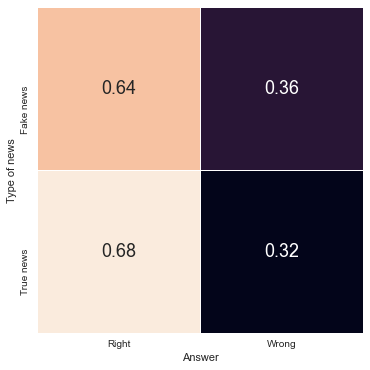

In [8]:
# Create the normalised version for the heatmap
true_fake_r_w_cont_normalised = pd.crosstab(true_fake_r_w['Type of news'], true_fake_r_w['Answer'], normalize='index')
true_fake_r_w_cont_normalised

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(true_fake_r_w_cont_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [9]:
data_bar_plot = true_fake_r_w.value_counts().to_frame().rename(columns={0:'count'}).reset_index()

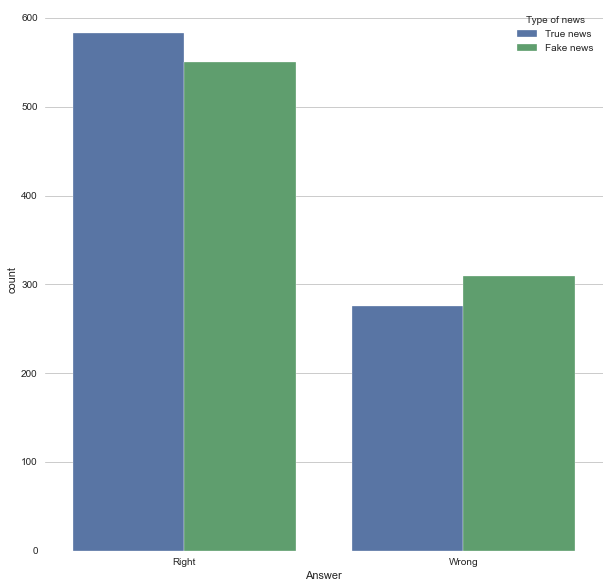

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(hue="Type of news", y="count", x="Answer",  data=data_bar_plot, ax=ax)
plt.show()

### Chi-Square

In [11]:
data_chi_square = chisq_and_posthoc_corrected(true_fake_r_w_cont)

Chi2 result of the contingency table: 2.6542225843196716, p-value: 0.10327523703986423

Post-hoc chi2 tests results:
('Fake news', 'True news'): p_value: 0.103275; corrected: 0.103275 (ns) reject: False


There is no difference in the two groups. It means the subject were not more likely to get right or wrong in case of a Fake news or a True news

## Number of people per number of mistakes

In [12]:
# Reshape the value into Categorical and reindex. Careful, index position is important for expected values
df.count_error = pd.Categorical(df.count_error, categories=['No error', '1 error', '2 errors'],ordered=True)

data = df['count_error'].value_counts().to_frame().reset_index()
data = data.sort_values(by=['index', 'count_error'])
data['count_expected'] = [0.25*data['count_error'].sum(), 0.5*data['count_error'].sum(), 0.25*data['count_error'].sum()]

### Barplot

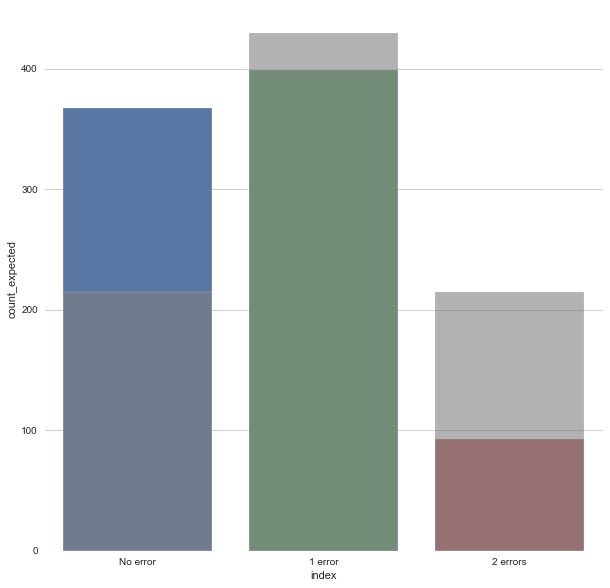

In [13]:
f, ax = plt.subplots(figsize=(10, 10))

sns.barplot( y="count_error", x="index",  data=data, ax=ax, alpha=1)
sns.barplot( y="count_expected", x="index",  data=data, ax=ax, alpha=0.6, color='grey')
plt.show()

### Goodness of fit

In [14]:
# TODO analysis of where

In [15]:
stats.gof.chisquare(f_obs= data['count_error'], f_exp=data['count_expected'], return_basic=False)

(179.1303841676368, 1.2657015367292102e-39)

The distribution of the sample is different than the expected distribution. It means we have less people than expected that did two errors, while there is more people than expected that did no errors

# Independence

The analysis about the different socio-demographic questions and their link with getting right or wrong to the different news are splitted into three majors sections. 
The first one is when we consider the different groups as separated into three categories (0 errors, 1 errors, 2 errors), the second one is when we consider the different groups separated by the 4 categories ( TR-FR, TR-FW, TW-FR, TW-FW), and ultimately the one on the two categories (r_w). 

Here we output a summary of all the tests ran with the different type of distinctions in the errors. To see the details of the analysis alongside the plots and the post-hoc tests, go to the annexes. 

In [16]:
dep_variables = {'r_w': 'chisquare', 'count_error': 'kruskal', 'cat_tf_rw': 'chisquare'}

ind_variables = {'age': 'recode_age', 
                 'gender': 'dm_genero', 
                 'uni-notuni': 'recode_education', 
                 'edu_levels': 'recode_education2',
                 'politics': 'recode_politics', 
                 'religious_belief': 'recode_religion',
                 'technological_knowledge': 'dm_tecnologia'}
list_results = []
for dv in dep_variables:
    method = dep_variables[dv]
    for iv_name in ind_variables:
        iv_col = ind_variables[iv_name]
        data = df[[iv_col, dv]]
        # Drop the na
        data = data.dropna()
        n_ = len(data)

        data_count = pd.crosstab(data[iv_col], data[dv])
        
        if method == 'kruskal':
            value_per_grp = data.groupby(iv_col)['count_error'].apply(list)
            stats, p_value = scipy.stats.kruskal(*value_per_grp)
            asterisks = get_asterisks_for_pval(p_value)
            
        elif method == 'chisquare':
            
            stat, p_value, dof, ex = chi2_contingency(data_count, correction=True)
            asterisks = get_asterisks_for_pval(p_value)
        result = {'Dep variable': dv, 'Ind variable': iv_name, 'Ind column': iv_col, 'N': n_, 'method': method, 'stat': stat, 'p_value': p_value, 'Sign.': asterisks}
        list_results.append(result)

        

In [17]:
pd.DataFrame(list_results)

,Dep variable,Ind variable,Ind column,N,method,stat,p_value,Sign.
0,r_w,age,recode_age,859,chisquare,0.049936,0.975341,ns
1,r_w,gender,dm_genero,859,chisquare,1.789204,0.181023,ns
2,r_w,uni-notuni,recode_education,858,chisquare,11.291120,0.000779,***
3,r_w,edu_levels,recode_education2,858,chisquare,12.605829,0.001831,**
4,r_w,politics,recode_politics,665,chisquare,10.695501,0.004759,**
5,r_w,religious_belief,recode_religion,772,chisquare,16.240164,0.000056,****
6,r_w,technological_knowledge,dm_tecnologia,856,chisquare,8.791611,0.012329,*
7,count_error,age,recode_age,859,kruskal,8.791611,0.810437,ns
8,count_error,gender,dm_genero,859,kruskal,8.791611,0.251450,ns
9,count_error,uni-notuni,recode_education,858,kruskal,8.791611,0.000956,***


The significative tests are given by the p_values and considered as significative if p < .05. The Sign. column indicate the level of significance. 
The different tests have a post-hoc analysis. In case of Kruskall wallis, the variable is ordinal, therefore the interpretation takes into account the *increase in error".
In case of the chi-square, it is an independent test and the interpretation is in terms of difference in the two groups. The analysis of the Adjusted residuals gives information in which group it is significatif and in which direction. 

# Annexes

## Difference for being better informed with the age

In [18]:
col_var = 'recode_age'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_age,,,
35-54,184,195,51
<=18-34,89,94,23
>55,94,110,19


In [19]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 859


In [20]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_age,,,
35-54,0.427907,0.453488,0.118605
<=18-34,0.432039,0.456311,0.111650
>55,0.421525,0.493274,0.085202


### Heatmap

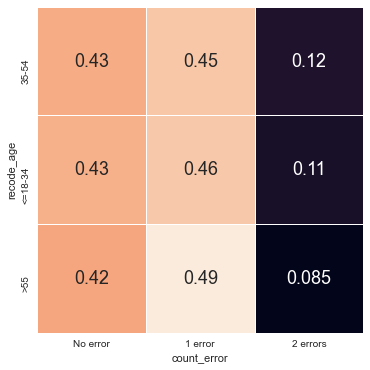

In [21]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [22]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,count_error,count
0,35-54,1 error,195
1,35-54,No error,184
2,>55,1 error,110
3,>55,No error,94
4,<=18-34,1 error,94
5,<=18-34,No error,89
6,35-54,2 errors,51
7,<=18-34,2 errors,23
8,>55,2 errors,19


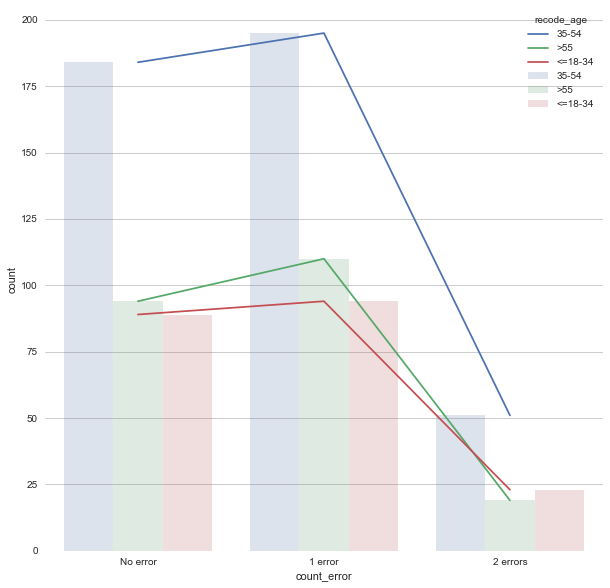

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [24]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [25]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=0.4203637268658092, pvalue=0.8104368437405006)

### Post-hoc: Dunn test

In [26]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,35-54,<=18-34,>55
35-54,1.0,1.0,1.0
<=18-34,1.0,1.0,1.0
>55,1.0,1.0,1.0


There is no difference due to age in getting more or less errors

## Difference due to gender

In [27]:
col_var = 'dm_genero'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,205,206,45
Masculino,162,193,48


In [28]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 859


In [29]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_genero,,,
Femenino,0.449561,0.451754,0.098684
Masculino,0.401985,0.478908,0.119107


### Heatmap

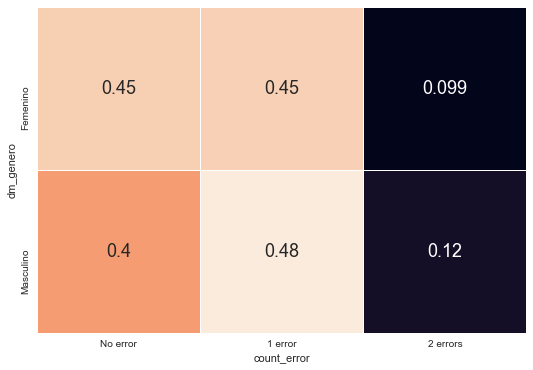

In [30]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [31]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,count_error,count
0,Femenino,1 error,206
1,Femenino,No error,205
2,Masculino,1 error,193
3,Masculino,No error,162
4,Masculino,2 errors,48
5,Femenino,2 errors,45


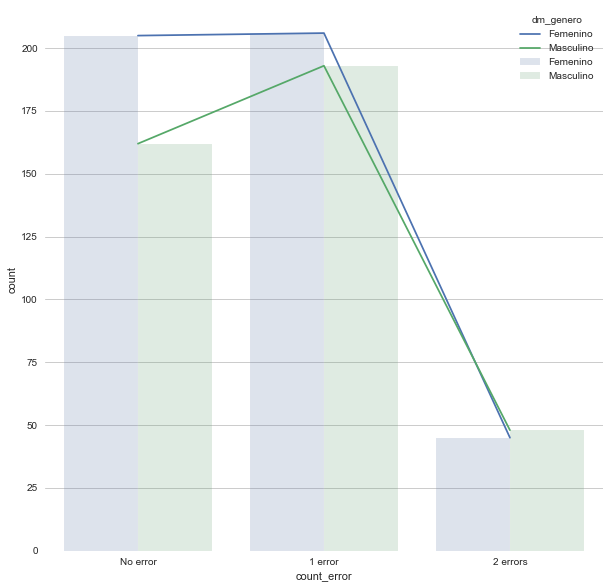

In [32]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [33]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [34]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=1.3152295278596062, pvalue=0.2514499992068521)

### Post-hoc: Dunn test

In [35]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Femenino,Masculino
Femenino,1.000000,0.130334
Masculino,0.130334,1.000000


## Difference due to Uni - None Uni

In [36]:
col_var = 'recode_education'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_education,,,
No_university_studies,145,206,47
University_studies,221,193,46


In [37]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 858


In [38]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_education,,,
No_university_studies,0.364322,0.517588,0.11809
University_studies,0.480435,0.419565,0.10000


### Heatmap

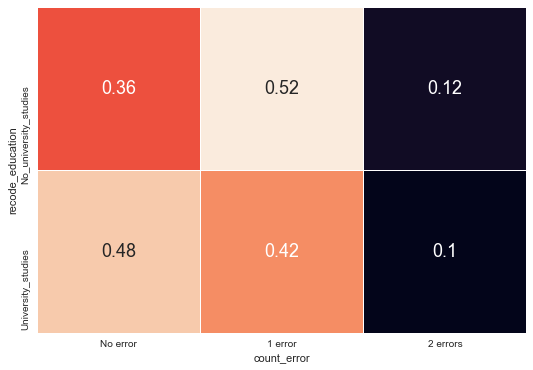

In [39]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [40]:
data_bar_plot = df[['count_error', col_var]].value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,count_error,recode_education,count
0,No error,University_studies,221
1,1 error,No_university_studies,206
2,1 error,University_studies,193
3,No error,No_university_studies,145
4,2 errors,No_university_studies,47
5,2 errors,University_studies,46


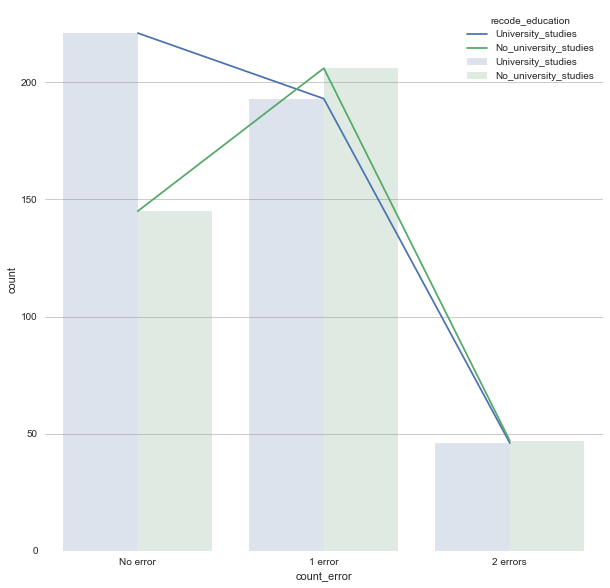

In [41]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [42]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [43]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=10.910010837261137, pvalue=0.000956459660105906)

### Post-hoc: Dunn test

In [44]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,No_university_studies,University_studies
No_university_studies,1.000000,0.001475
University_studies,0.001475,1.000000


The adjusted p-value for the difference between University and No university is 0.001475, thus the two groups are significantly different at < .005

## Difference due to edu level

In [45]:
col_var = 'recode_education2'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_education2,,,
up_to_bac_3,83,125,32
up_to_secondaria,62,81,15
up_to_university_level,221,193,46


In [46]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 858


In [47]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_education2,,,
up_to_bac_3,0.345833,0.520833,0.133333
up_to_secondaria,0.392405,0.512658,0.094937
up_to_university_level,0.480435,0.419565,0.100000


### Heatmap

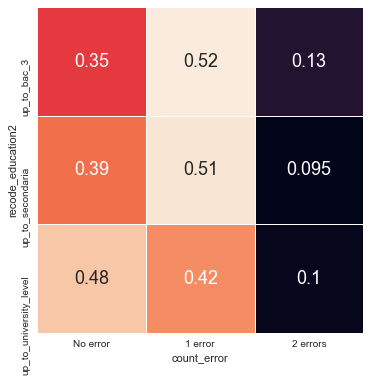

In [48]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [49]:
data_bar_plot = df[['count_error', col_var]].value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,count_error,recode_education2,count
0,No error,up_to_university_level,221
1,1 error,up_to_university_level,193
2,1 error,up_to_bac_3,125
3,No error,up_to_bac_3,83
4,1 error,up_to_secondaria,81
5,No error,up_to_secondaria,62
6,2 errors,up_to_university_level,46
7,2 errors,up_to_bac_3,32
8,2 errors,up_to_secondaria,15


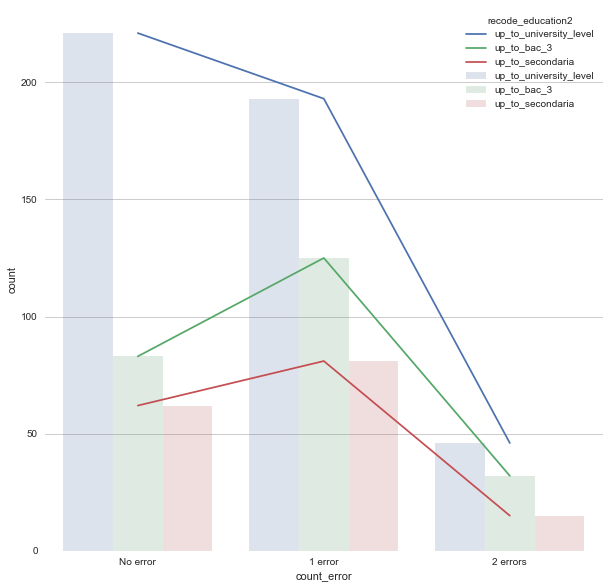

In [50]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [51]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [52]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=11.21490252861373, pvalue=0.003670412357238546)

### Post-hoc: Dunn test

In [53]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,up_to_bac_3,up_to_secondaria,up_to_university_level
up_to_bac_3,1.000000,0.707764,0.002523
up_to_secondaria,0.707764,1.000000,0.351760
up_to_university_level,0.002523,0.351760,1.000000


From the results of Dunn’s test we can observe the following:

  * The adjusted p-value for the difference between `up_to_bac_3` and `up_to_secondaria` is **0.707764**.
    
  * The adjusted p-value for the difference between `up_to_secondaria` and `up_to_university_level` is **0.351760**.
    
  * The adjusted p-value for the difference between `up_to_university_level` and `up_to_bac_3` is **0.002523**.

Thus, the only two groups that are statistically significantly different at α = .05 are `up_to_university_level` and `up_to_bac_3`

## Difference with the political parties

In [54]:
col_var = 'recode_politics'
data = df[[col_var, 'count_error']]
# Drop Np.NaN
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,48,76,13
Derecha,63,80,25
Izquierda,176,144,40


In [55]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 665


In [56]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_politics,,,
Centro,0.350365,0.554745,0.094891
Derecha,0.375000,0.476190,0.148810
Izquierda,0.488889,0.400000,0.111111


### Heatmap

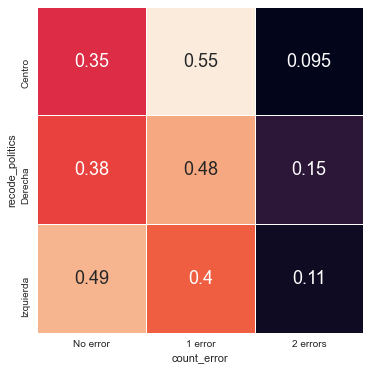

In [57]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [58]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,count_error,count
0,Izquierda,No error,176
1,Izquierda,1 error,144
2,Derecha,1 error,80
3,Centro,1 error,76
4,Derecha,No error,63
5,Centro,No error,48
6,Izquierda,2 errors,40
7,Derecha,2 errors,25
8,Centro,2 errors,13


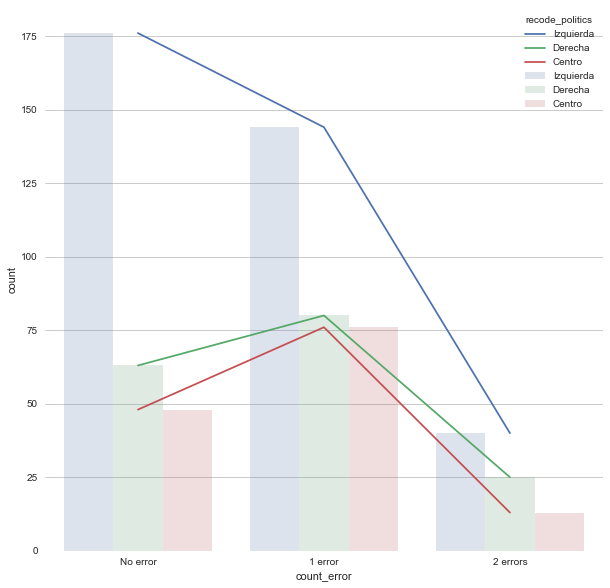

In [59]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [60]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [61]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=11.34863304181378, pvalue=0.003433014568308653)

### Post-hoc: Dunn test

In [62]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Centro,Derecha,Izquierda
Centro,1.000000,1.000000,0.095985
Derecha,1.000000,1.000000,0.038821
Izquierda,0.095985,0.038821,1.000000


From the results of Dunn’s test we can observe the following:
  * The adjusted p-value for the difference between `Centro` and `Derecha` is **1**.
  * The adjusted p-value for the difference between `Centro` and `Izquierda` is **1**.
  * The adjusted p-value for the difference between `Izquierda` and `Derecha` is **0.038821**.

Thus, the only two groups that are statistically significantly different at α = .05 are `Izquierda` and `Derecha`

## Difference with the religious believes

In [63]:
col_var = 'recode_religion'
data = df[[col_var, 'count_error']]
# Drop the na
data = data.dropna()
n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
recode_religion,,,
No religious,172,135,32
Religious,156,223,54


In [64]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 772


In [65]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
recode_religion,,,
No religious,0.507375,0.398230,0.094395
Religious,0.360277,0.515012,0.124711


### Heatmap

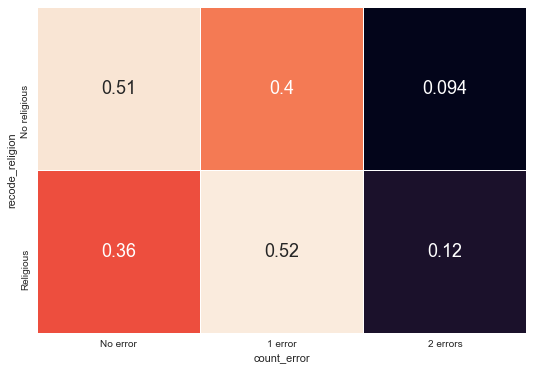

In [66]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [67]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,count_error,count
0,Religious,1 error,223
1,No religious,No error,172
2,Religious,No error,156
3,No religious,1 error,135
4,Religious,2 errors,54
5,No religious,2 errors,32


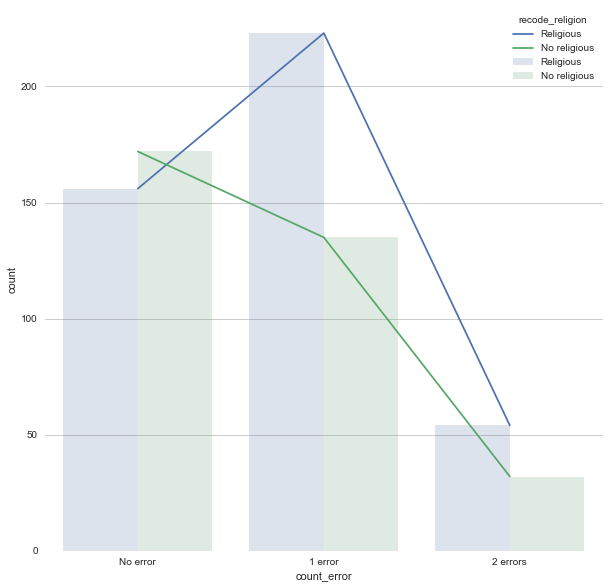

In [68]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [69]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [70]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=14.779004795671312, pvalue=0.00012087380971051312)

### Post-hoc: Dunn test

In [71]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,No religious,Religious
No religious,1.000000,0.000096
Religious,0.000096,1.000000


From the results of Dunn’s test we can observe the following:
  * The adjusted p-value for the difference between `Atheists/Agnostics` and `Believers` is **0.000096**.

Thus, the two groups that are statistically significantly different at α = .05.

## Difference due to level of technology knowledge

In [72]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'count_error']]
# Drop the NS/NC
data= data[data[col_var] != 'NS/NC']
# Drop the na
data = data.dropna()

n_ = len(data)

data_count = pd.crosstab(data[col_var], data['count_error'])

data_count

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,196,175,39
Básica,27,40,9
Media,142,183,45


In [73]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [74]:
data_count_normalised = pd.crosstab(  df[col_var],df['count_error'], normalize='index')
data_count_normalised

count_error,No error,1 error,2 errors
dm_tecnologia,,,
Avanzada,0.478049,0.426829,0.095122
Básica,0.355263,0.526316,0.118421
Media,0.383784,0.494595,0.121622


### Heatmap

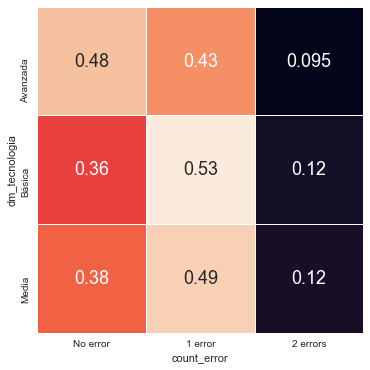

In [75]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

### Barplot

In [76]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,count_error,count
0,Avanzada,No error,196
1,Media,1 error,183
2,Avanzada,1 error,175
3,Media,No error,142
4,Media,2 errors,45
5,Básica,1 error,40
6,Avanzada,2 errors,39
7,Básica,No error,27
8,Básica,2 errors,9


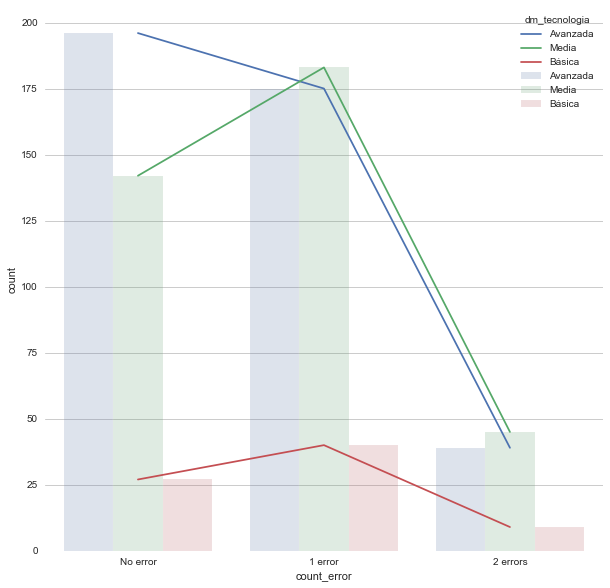

In [77]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='count_error',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

### Kruskal-Wallis H test

In [78]:
value_per_grp = data.groupby(col_var)['count_error'].apply(list)

In [79]:
scipy.stats.kruskal(*value_per_grp)

KruskalResult(statistic=7.298091720263974, pvalue=0.026015939785640943)

### Post-hoc: Dunn test

In [80]:
sp.posthoc_dunn(data, val_col='count_error', group_col=col_var, p_adjust = 'bonferroni')

,Avanzada,Básica,Media
Avanzada,1.000000,0.180719,0.024571
Básica,0.180719,1.000000,1.000000
Media,0.024571,1.000000,1.000000


From the results of Dunn’s test we can observe the following:
  * The adjusted p-value for the difference between `Avanzada` and `Básica` is **0.180719**.
  * The adjusted p-value for the difference between `Básica` and `Media` is **1**.
  * The adjusted p-value for the difference between `Media` and `Avanzada` is **0.024571**.

Thus, the only two groups that are statistically significantly different at α = .05 are `Media` and `Avanzada`

## Analysis of 4 categories
Here I redo the analysis using the fourth categories created by María del Carmen

In [81]:
variables_to_test = ['recode_age', 'dm_genero','recode_education', 'recode_politics','recode_religion', 'dm_tecnologia']


### Difference with age

In [82]:
col_var = 'recode_age'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
35-54,184,105,90,51
<=18-34,89,60,34,23
>55,94,51,59,19


In [83]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [84]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_age,,,,
35-54,0.427907,0.244186,0.209302,0.118605
<=18-34,0.432039,0.291262,0.165049,0.111650
>55,0.421525,0.228700,0.264574,0.085202


#### Heatmap

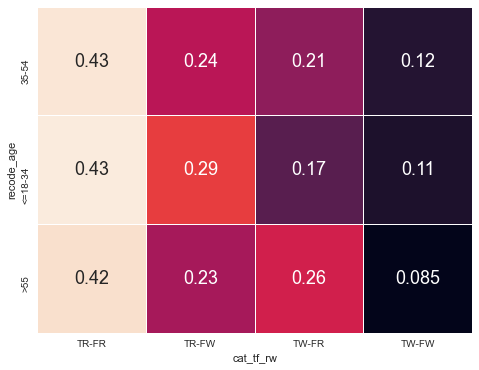

In [85]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [86]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,cat_tf_rw,count
0,35-54,TR-FR,184
1,35-54,TR-FW,105
2,>55,TR-FR,94
3,35-54,TW-FR,90
4,<=18-34,TR-FR,89
5,<=18-34,TR-FW,60
6,>55,TW-FR,59
7,>55,TR-FW,51
8,35-54,TW-FW,51
9,<=18-34,TW-FR,34


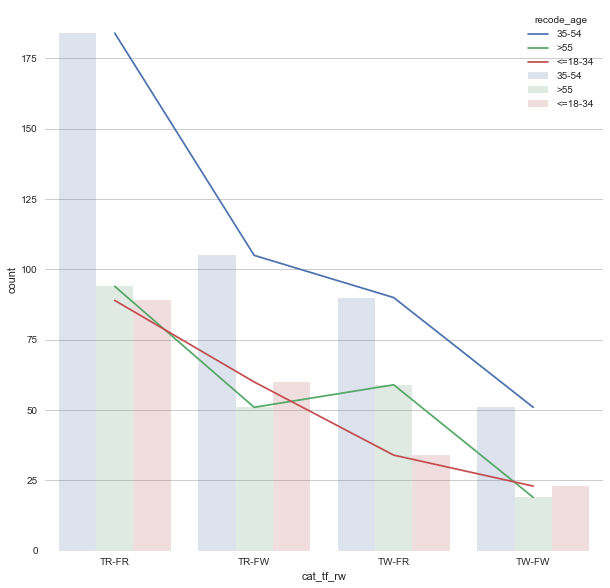

In [87]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [88]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 8.453573758574958, p-value: 0.20671991477672064



,recode_age,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,35-54,TR-FR,0.039505,0.968488,1.000000,False,ns
1,35-54,TR-FW,-0.491638,0.622975,1.000000,False,ns
2,35-54,TW-FR,-0.267740,0.788899,1.000000,False,ns
3,35-54,TW-FW,0.976399,0.328867,1.000000,False,ns
4,<=18-34,TR-FR,0.159661,0.873148,1.000000,False,ns
5,<=18-34,TR-FW,1.510405,0.130940,1.000000,False,ns
6,<=18-34,TW-FR,-1.929379,0.053684,0.644206,False,ns
7,<=18-34,TW-FW,0.179340,0.857671,1.000000,False,ns
8,>55,TR-FR,-0.200546,0.841054,1.000000,False,ns
9,>55,TR-FW,-0.910270,0.362680,1.000000,False,ns


### Difference with gender

In [89]:
col_var = 'dm_genero'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,205,116,90,45
Masculino,162,100,93,48


In [90]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [91]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_genero,,,,
Femenino,0.449561,0.254386,0.197368,0.098684
Masculino,0.401985,0.248139,0.230769,0.119107


#### Heatmap

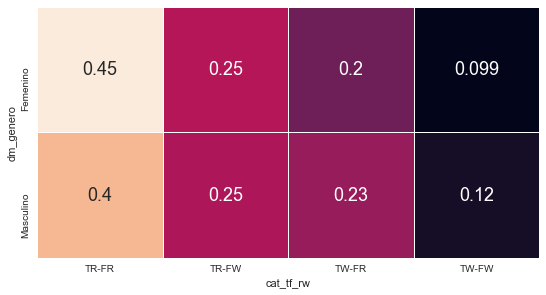

In [92]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [93]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,cat_tf_rw,count
0,Femenino,TR-FR,205
1,Masculino,TR-FR,162
2,Femenino,TR-FW,116
3,Masculino,TR-FW,100
4,Masculino,TW-FR,93
5,Femenino,TW-FR,90
6,Masculino,TW-FW,48
7,Femenino,TW-FW,45


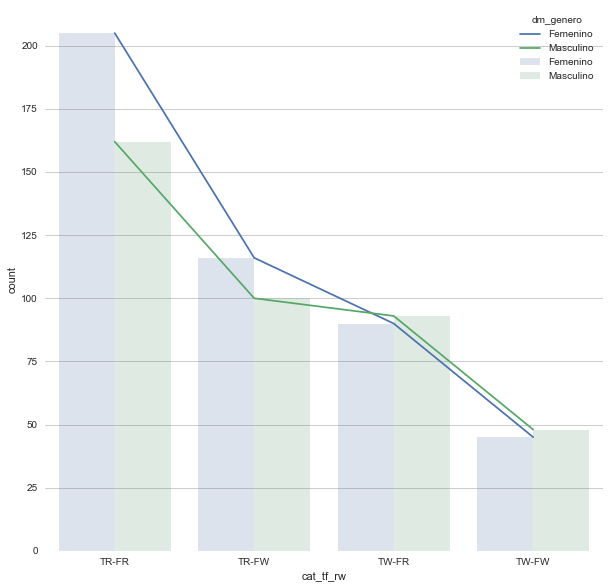

In [94]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [95]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 3.111048641349182, p-value: 0.3748185398656928



,dm_genero,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Femenino,TR-FR,1.406716,0.159512,1.0,False,ns
1,Femenino,TR-FW,0.210606,0.833195,1.0,False,ns
2,Femenino,TW-FR,-1.193135,0.232816,1.0,False,ns
3,Femenino,TW-FW,-0.961356,0.336373,1.0,False,ns
4,Masculino,TR-FR,-1.406716,0.159512,1.0,False,ns
5,Masculino,TR-FW,-0.210606,0.833195,1.0,False,ns
6,Masculino,TW-FR,1.193135,0.232816,1.0,False,ns
7,Masculino,TW-FW,0.961356,0.336373,1.0,False,ns


### Difference with Uni vs Non Uni

In [96]:
col_var = 'recode_education'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No_university_studies,145,113,93,47
University_studies,221,103,90,46


In [97]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [98]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_education,,,,
No_university_studies,0.364322,0.283920,0.233668,0.11809
University_studies,0.480435,0.223913,0.195652,0.10000


#### Heatmap

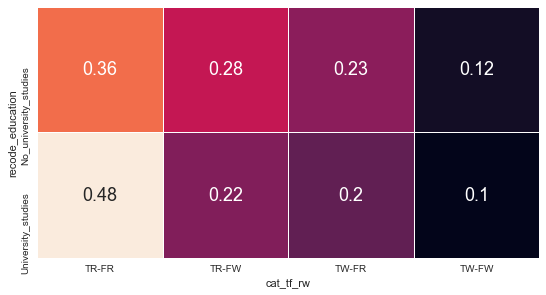

In [99]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [100]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_education,cat_tf_rw,count
0,University_studies,TR-FR,221
1,No_university_studies,TR-FR,145
2,No_university_studies,TR-FW,113
3,University_studies,TR-FW,103
4,No_university_studies,TW-FR,93
5,University_studies,TW-FR,90
6,No_university_studies,TW-FW,47
7,University_studies,TW-FW,46


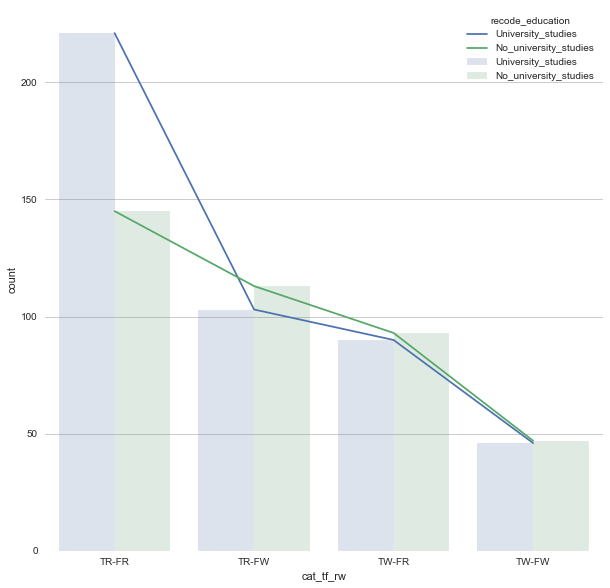

In [101]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [102]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.886195968364882, p-value: 0.007783348266488882



,recode_education,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No_university_studies,TR-FR,-3.429434,0.000605,0.004839,True,**
1,No_university_studies,TR-FW,2.019614,0.043423,0.347387,False,ns
2,No_university_studies,TW-FR,1.355673,0.175203,1.000000,False,ns
3,No_university_studies,TW-FW,0.850044,0.395301,1.000000,False,ns
4,University_studies,TR-FR,3.429434,0.000605,0.004839,True,**
5,University_studies,TR-FW,-2.019614,0.043423,0.347387,False,ns
6,University_studies,TW-FR,-1.355673,0.175203,1.000000,False,ns
7,University_studies,TW-FW,-0.850044,0.395301,1.000000,False,ns


### Difference with political parties

In [103]:
col_var = 'recode_politics'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,48,38,38,13
Derecha,63,48,32,25
Izquierda,176,76,68,40


In [104]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [105]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_politics,,,,
Centro,0.350365,0.277372,0.277372,0.094891
Derecha,0.375000,0.285714,0.190476,0.148810
Izquierda,0.488889,0.211111,0.188889,0.111111


#### Heatmap

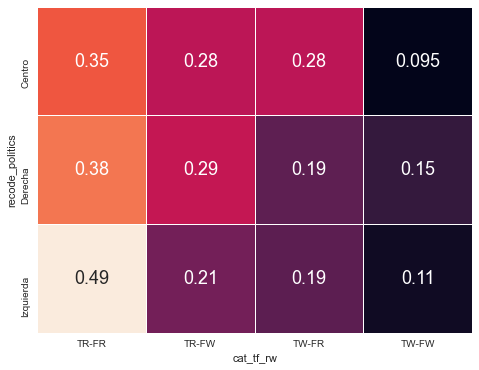

In [106]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [107]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,cat_tf_rw,count
0,Izquierda,TR-FR,176
1,Izquierda,TR-FW,76
2,Izquierda,TW-FR,68
3,Derecha,TR-FR,63
4,Derecha,TR-FW,48
5,Centro,TR-FR,48
6,Izquierda,TW-FW,40
7,Centro,TW-FR,38
8,Centro,TR-FW,38
9,Derecha,TW-FR,32


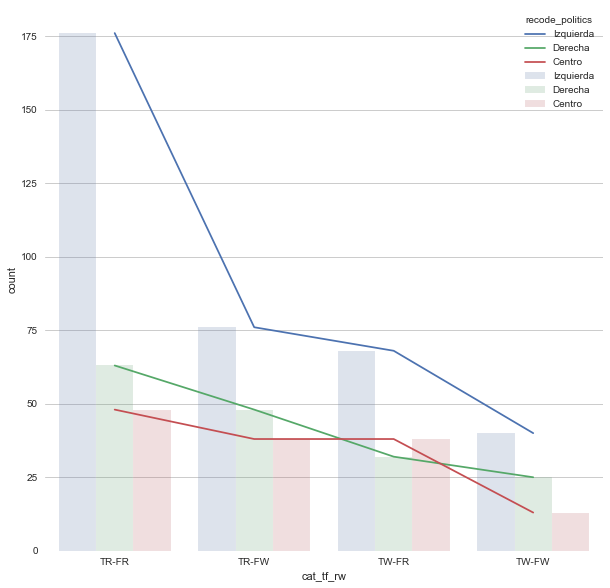

In [108]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [109]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 15.688724720518637, p-value: 0.015525893634485515



,recode_politics,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Centro,TR-FR,-2.153871,0.031250,0.375003,False,ns
1,Centro,TR-FW,1.033186,0.301517,1.000000,False,ns
2,Centro,TW-FR,2.262658,0.023657,0.283881,False,ns
3,Centro,TW-FW,-0.914556,0.360425,1.000000,False,ns
4,Derecha,TR-FR,-1.712683,0.086771,1.000000,False,ns
5,Derecha,TR-FW,1.470631,0.141391,1.000000,False,ns
6,Derecha,TW-FR,-0.630086,0.528638,1.000000,False,ns
7,Derecha,TW-FW,1.468513,0.141965,1.000000,False,ns
8,Izquierda,TR-FR,3.241731,0.001188,0.014257,True,*
9,Izquierda,TR-FW,-2.121035,0.033919,0.407027,False,ns


### Difference with Religious belief

In [110]:
col_var = 'recode_religion'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var], data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])

data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
No religious,172,80,55,32
Religious,156,117,106,54


In [111]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [112]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
recode_religion,,,,
No religious,0.507375,0.235988,0.162242,0.094395
Religious,0.360277,0.270208,0.244804,0.124711


#### Heatmap

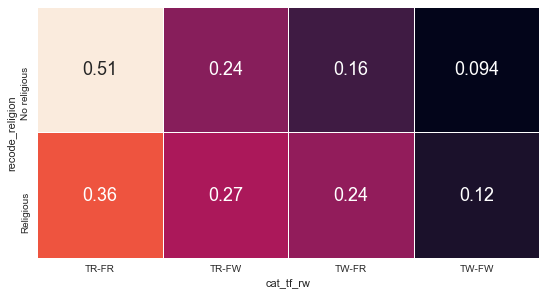

In [113]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [114]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,cat_tf_rw,count
0,No religious,TR-FR,172
1,Religious,TR-FR,156
2,Religious,TR-FW,117
3,Religious,TW-FR,106
4,No religious,TR-FW,80
5,No religious,TW-FR,55
6,Religious,TW-FW,54
7,No religious,TW-FW,32


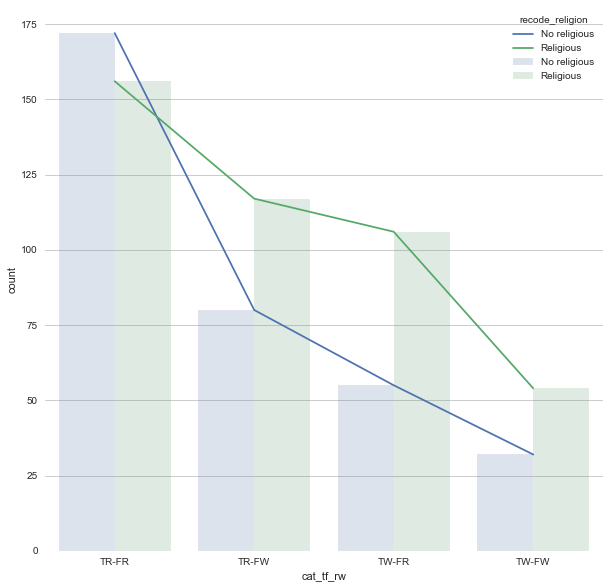

In [115]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [116]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 18.339212362105243, p-value: 0.0003743805774755582



,recode_religion,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No religious,TR-FR,4.103263,0.000041,0.000326,True,***
1,No religious,TR-FW,-1.082333,0.279104,1.000000,False,ns
2,No religious,TW-FR,-2.802193,0.005076,0.040605,True,*
3,No religious,TW-FW,-1.328659,0.183960,1.000000,False,ns
4,Religious,TR-FR,-4.103263,0.000041,0.000326,True,***
5,Religious,TR-FW,1.082333,0.279104,1.000000,False,ns
6,Religious,TW-FR,2.802193,0.005076,0.040605,True,*
7,Religious,TW-FW,1.328659,0.183960,1.000000,False,ns


### Difference with technological knowledge

In [117]:
col_var = 'dm_tecnologia'
data = df[[col_var, 'cat_tf_rw']]
data_count = pd.crosstab(data[col_var],  data['cat_tf_rw'])
data_count2 = pd.crosstab( data['cat_tf_rw'], data[col_var])
data_count

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,196,99,76,39
Básica,27,17,23,9
Media,142,100,83,45


In [118]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [119]:
data_count_normalised = pd.crosstab(  df[col_var],df['cat_tf_rw'], normalize='index')
data_count_normalised

cat_tf_rw,TR-FR,TR-FW,TW-FR,TW-FW
dm_tecnologia,,,,
Avanzada,0.478049,0.241463,0.185366,0.095122
Básica,0.355263,0.223684,0.302632,0.118421
Media,0.383784,0.270270,0.224324,0.121622


#### Heatmap

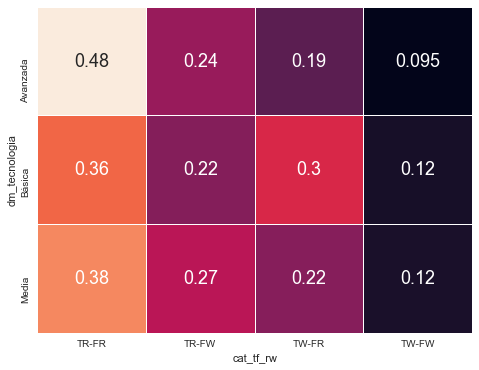

In [120]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [121]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,cat_tf_rw,count
0,Avanzada,TR-FR,196
1,Media,TR-FR,142
2,Media,TR-FW,100
3,Avanzada,TR-FW,99
4,Media,TW-FR,83
5,Avanzada,TW-FR,76
6,Media,TW-FW,45
7,Avanzada,TW-FW,39
8,Básica,TR-FR,27
9,Básica,TW-FR,23


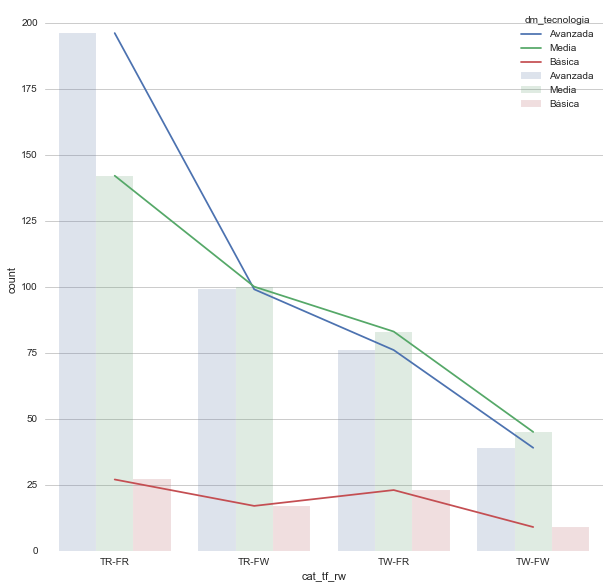

In [122]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x='cat_tf_rw',  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [123]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.851089969249614, p-value: 0.06537445362063155



,dm_tecnologia,cat_tf_rw,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Avanzada,TR-FR,2.929492,0.003395,0.040742,True,*
1,Avanzada,TR-FW,-0.702213,0.482546,1.000000,False,ns
2,Avanzada,TW-FR,-1.868321,0.061717,0.740608,False,ns
3,Avanzada,TW-FW,-1.218994,0.222847,1.000000,False,ns
4,Básica,TR-FR,-1.313678,0.188955,1.000000,False,ns
5,Básica,TR-FW,-0.602437,0.546883,1.000000,False,ns
6,Básica,TW-FR,2.009177,0.044518,0.534220,False,ns
7,Básica,TW-FW,0.286904,0.774186,1.000000,False,ns
8,Media,TR-FR,-2.199886,0.027815,0.333780,False,ns
9,Media,TR-FW,1.054021,0.291873,1.000000,False,ns


## Analysis using Right-Wrong distinction

In [124]:
dep_var = 'r_w'

### Difference with age

In [125]:
col_var = 'recode_age'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

r_w,R,W
recode_age,,
35-54,184,246
<=18-34,89,117
>55,94,129


In [126]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [127]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
recode_age,,
35-54,0.427907,0.572093
<=18-34,0.432039,0.567961
>55,0.421525,0.578475


#### Heatmap

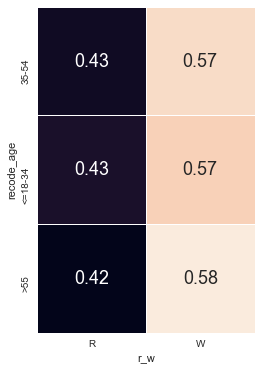

In [128]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [129]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_age,r_w,count
0,35-54,W,246
1,35-54,R,184
2,>55,W,129
3,<=18-34,W,117
4,>55,R,94
5,<=18-34,R,89


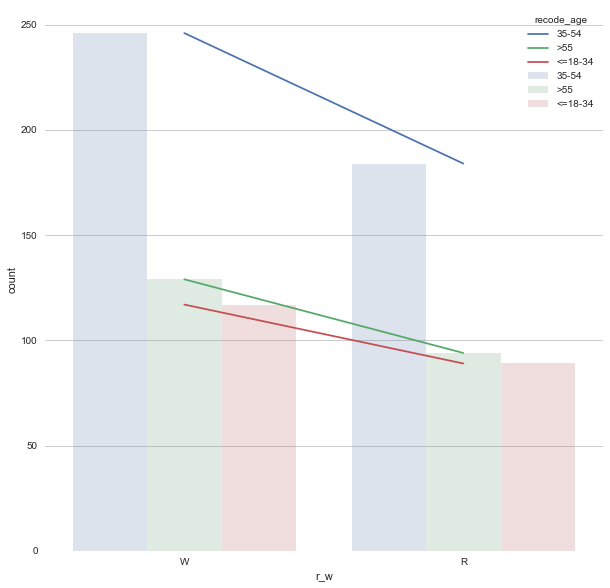

In [130]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [131]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 0.04993554964597885, p-value: 0.9753413420693046



,recode_age,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,35-54,R,0.039505,0.968488,1.0,False,ns
1,35-54,W,-0.039505,0.968488,1.0,False,ns
2,<=18-34,R,0.159661,0.873148,1.0,False,ns
3,<=18-34,W,-0.159661,0.873148,1.0,False,ns
4,>55,R,-0.200546,0.841054,1.0,False,ns
5,>55,W,0.200546,0.841054,1.0,False,ns


### Difference with gender

In [132]:
col_var = 'dm_genero'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

r_w,R,W
dm_genero,,
Femenino,205,251
Masculino,162,241


In [133]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [134]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
dm_genero,,
Femenino,0.449561,0.550439
Masculino,0.401985,0.598015


#### Heatmap

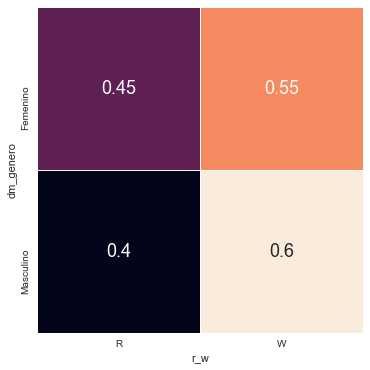

In [135]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [136]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_genero,r_w,count
0,Femenino,W,251
1,Masculino,W,241
2,Femenino,R,205
3,Masculino,R,162


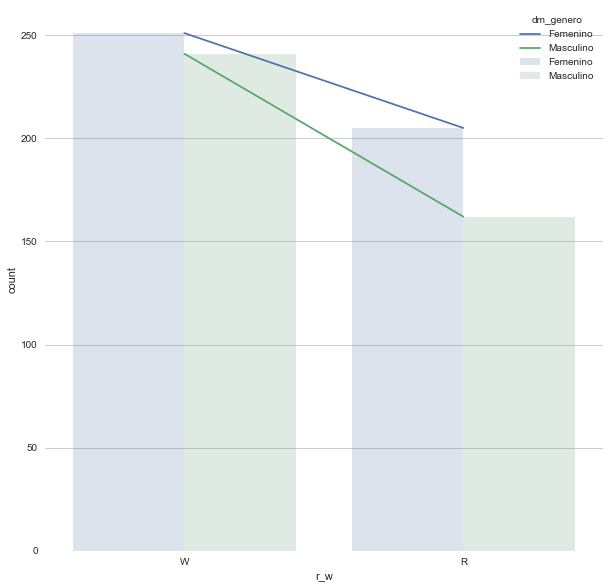

In [137]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [138]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 1.7892042052701642, p-value: 0.1810231526560922



,dm_genero,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Femenino,R,1.406716,0.159512,0.638046,False,ns
1,Femenino,W,-1.406716,0.159512,0.638046,False,ns
2,Masculino,R,-1.406716,0.159512,0.638046,False,ns
3,Masculino,W,1.406716,0.159512,0.638046,False,ns


### Difference with Uni vs Non Uni

In [139]:
col_var = 'recode_education'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

r_w,R,W
recode_education,,
No_university_studies,145,253
University_studies,221,239


In [140]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [141]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
recode_education,,
No_university_studies,0.364322,0.635678
University_studies,0.480435,0.519565


#### Heatmap

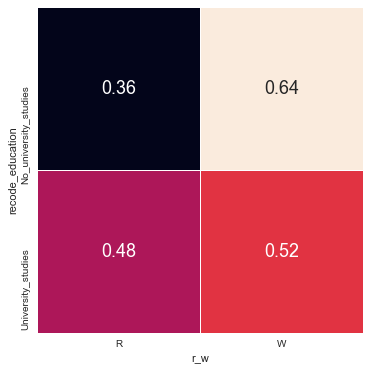

In [142]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [143]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_education,r_w,count
0,No_university_studies,W,253
1,University_studies,W,239
2,University_studies,R,221
3,No_university_studies,R,145


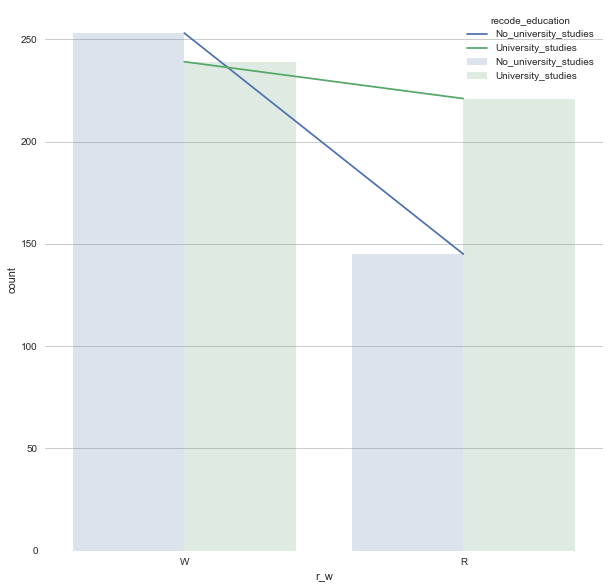

In [144]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [145]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 11.29112033414732, p-value: 0.0007787867192997264



,recode_education,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No_university_studies,R,-3.429434,0.000605,0.002419,True,**
1,No_university_studies,W,3.429434,0.000605,0.002419,True,**
2,University_studies,R,3.429434,0.000605,0.002419,True,**
3,University_studies,W,-3.429434,0.000605,0.002419,True,**


### Difference with political parties

In [146]:
col_var = 'recode_politics'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count

r_w,R,W
recode_politics,,
Centro,48,89
Derecha,63,105
Izquierda,176,184


In [147]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [148]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
recode_politics,,
Centro,0.350365,0.649635
Derecha,0.375000,0.625000
Izquierda,0.488889,0.511111


#### Heatmap

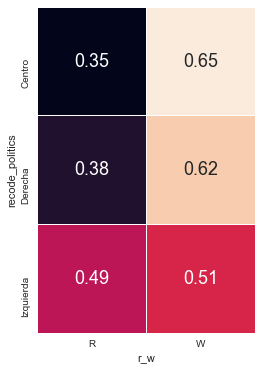

In [149]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [150]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_politics,r_w,count
0,Izquierda,W,184
1,Izquierda,R,176
2,Derecha,W,105
3,Centro,W,89
4,Derecha,R,63
5,Centro,R,48


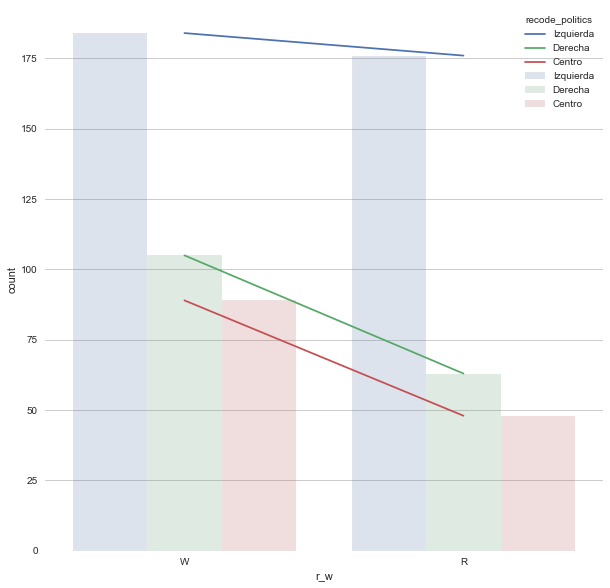

In [151]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [152]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 10.69550058757548, p-value: 0.004758844968845993



,recode_politics,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Centro,R,-2.153871,0.031250,0.187502,False,ns
1,Centro,W,2.153871,0.031250,0.187502,False,ns
2,Derecha,R,-1.712683,0.086771,0.520625,False,ns
3,Derecha,W,1.712683,0.086771,0.520625,False,ns
4,Izquierda,R,3.241731,0.001188,0.007128,True,**
5,Izquierda,W,-3.241731,0.001188,0.007128,True,**


### Difference with Religious belief

In [153]:
col_var = 'recode_religion'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var], data[dep_var])
data_count2 = pd.crosstab( data[dep_var], data[col_var])

data_count

r_w,R,W
recode_religion,,
No religious,172,167
Religious,156,277


In [154]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [155]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
recode_religion,,
No religious,0.507375,0.492625
Religious,0.360277,0.639723


#### Heatmap

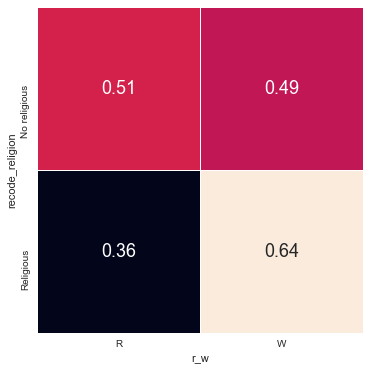

In [156]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [157]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,recode_religion,r_w,count
0,Religious,W,277
1,No religious,R,172
2,No religious,W,167
3,Religious,R,156


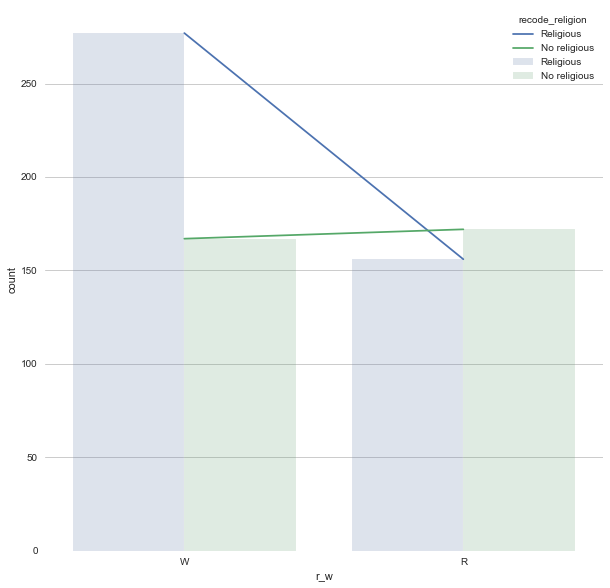

In [158]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [159]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 16.240163830976343, p-value: 5.5798529961421525e-05



,recode_religion,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,No religious,R,4.103263,0.000041,0.000163,True,***
1,No religious,W,-4.103263,0.000041,0.000163,True,***
2,Religious,R,-4.103263,0.000041,0.000163,True,***
3,Religious,W,4.103263,0.000041,0.000163,True,***


### Difference with technological knowledge

In [160]:
col_var = 'dm_tecnologia'
data = df[[col_var, dep_var]]
data_count = pd.crosstab(data[col_var],  data[dep_var])
data_count2 = pd.crosstab( data[dep_var], data[col_var])
data_count

r_w,R,W
dm_tecnologia,,
Avanzada,196,214
Básica,27,49
Media,142,228


In [161]:
print('Size of N for that test: {}'.format(n_))

Size of N for that test: 856


In [162]:
data_count_normalised = pd.crosstab(  df[col_var],df[dep_var], normalize='index')
data_count_normalised

r_w,R,W
dm_tecnologia,,
Avanzada,0.478049,0.521951
Básica,0.355263,0.644737
Media,0.383784,0.616216


#### Heatmap

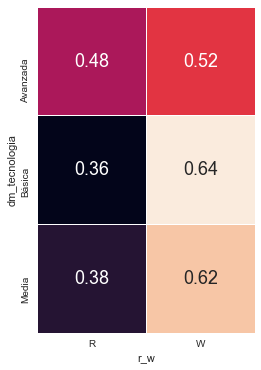

In [163]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_count_normalised, 
            annot=True, 
            fmt=".2g", 
            linewidths=.5, 
            #cmap="YlGnBu", 
            cbar=False,
            square=True,
            annot_kws={"size": 18},
            ax=ax)
plt.show()

#### Barplot

In [164]:
data_bar_plot = data.value_counts().to_frame().rename(columns={0:'count'}).reset_index()
data_bar_plot

,dm_tecnologia,r_w,count
0,Media,W,228
1,Avanzada,W,214
2,Avanzada,R,196
3,Media,R,142
4,Básica,W,49
5,Básica,R,27


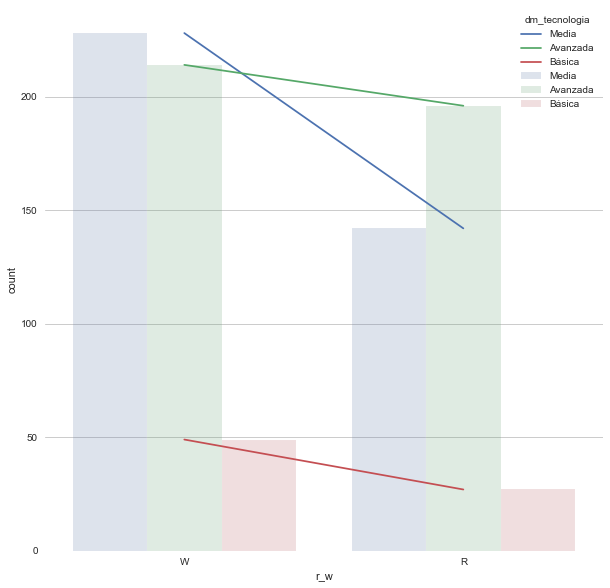

In [165]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax)
sns.barplot(hue=col_var, y="count", x=dep_var,  data=data_bar_plot, ax=ax, alpha=0.2)
plt.show()

#### Chisquare of independence test

In [166]:
chisq_posthoc_corrected(data_count)

Chi2 result of the contingency table: 8.791610710945442, p-value: 0.01232894714104229



,dm_tecnologia,r_w,Adj. Res.,p_value,p_value_corrected,reject,asterisques
0,Avanzada,R,2.929492,0.003395,0.020371,True,*
1,Avanzada,W,-2.929492,0.003395,0.020371,True,*
2,Básica,R,-1.313678,0.188955,1.000000,False,ns
3,Básica,W,1.313678,0.188955,1.000000,False,ns
4,Media,R,-2.199886,0.027815,0.166890,False,ns
5,Media,W,2.199886,0.027815,0.166890,False,ns


## Stratified contingency table to control the variable education

The previous results may have all be cofounded by the education level of the participants. To see the relationship of the different variables on the variable Right-Wrong, we will use the Cochran-Mantel-Haenszel Test to control it

### Education and politics with people being Right or Wrong

In [167]:
ind_vars = ['recode_education', 'recode_politics']
dep_var = 'r_w'

In [168]:
data = df[[dep_var, *ind_vars]]
data = data.dropna()
data[dep_var] = data[dep_var].map(dict(R=1, W=0))
data.head()

,r_w,recode_education,recode_politics
0,0,No_university_studies,Izquierda
1,0,No_university_studies,Izquierda
3,0,University_studies,Centro
5,0,No_university_studies,Derecha
7,0,University_studies,Derecha


In [169]:
data_count = pd.crosstab([data[ind_vars[0]], data[ind_vars[1]]],data[dep_var], margins=True)
data_count

r_w                                      0    1  All
recode_education      recode_politics               
No_university_studies Centro            39   16   55
                      Derecha           42   24   66
                      Izquierda         99   66  165
University_studies    Centro            50   32   82
                      Derecha           63   39  102
                      Izquierda         85  109  194
All                                    378  286  664

## GLM [WIP]

In [200]:
df_news['answer'] = df_news.replace({'Right': int(1), 'Wrong': int(0)})
df_news['id_sondea'] = df_news['id_sondea'].astype('category')

df_mm = df_news[['answer', 'id_sondea', 'recode_politics', 'news_title']]
#df_mm = df_news[['answer', 'id_sondea', 'recode_education', 'recode_politics', 'type_news_x']]

df_mm = df_mm.dropna()
df_mm['recode_politics'] = df_mm['recode_politics'].astype('category')
formula = "answer  ~ relevel(recode_politics, ref = 'Izquierda') + (1|news_title) + (1|id_sondea)"
model = Lmer(formula ,
             data=df_mm, family = 'binomial')

model.fit(summarize=True)

boundary (singular) fit: see ?isSingular 

Formula: answer~relevel(recode_politics,ref='Izquierda')+(1|news_title)+(1|id_sondea)

Family: binomial	 Inference: parametric

Number of observations: 1330	 Groups: {'id_sondea': 665.0, 'news_title': 20.0}

Log-likelihood: -109.013 	 AIC: 228.026

Random effects:

                   Name       Var     Std
id_sondea   (Intercept)  3753.217  61.264
news_title  (Intercept)     0.000   0.000

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-13.695,-16.043,-11.347,1.198,0.000,0.000,0.00,0.000,0.000,0.000,-11.430,0.000,***
"relevel(recode_politics, ref = ""Izquierda"")Centro",-0.443,-4.329,3.443,1.983,0.642,0.013,31.27,0.391,0.013,0.969,-0.224,0.823,
"relevel(recode_politics, ref = ""Izquierda"")Derecha",-0.877,-5.067,3.314,2.138,0.416,0.006,27.49,0.294,0.006,0.965,-0.410,0.682,


In [202]:
df_news['answer'] = df_news.replace({'Right': int(1), 'Wrong': int(0)})
df_news['id_sondea'] = df_news['id_sondea'].astype('category')

df_mm = df_news[['answer', 'id_sondea', 'recode_education', 'news_title', 'dm_tecnologia']]
#df_mm = df_news[['answer', 'id_sondea', 'recode_education', 'recode_politics', 'type_news_x']]

df_mm = df_mm.dropna()
df_mm['recode_education'] = df_mm['recode_education'].astype('category')
df_mm['recode_education'] = df_mm['recode_education'].astype('category')

#formula = "answer  ~ recode_education + dm_technologia + (1|id_sondea) + (1|news_title)"
formula = "answer  ~ relevel(recode_education, ref ='University_studies') + (1|id_sondea)"

model = Lmer(formula ,data=df_mm, family = 'binomial')

model.fit(summarize=True)

Formula: answer~relevel(recode_education,ref='University_studies')+(1|id_sondea)

Family: binomial	 Inference: parametric

Number of observations: 1710	 Groups: {'id_sondea': 855.0}

Log-likelihood: -136.464 	 AIC: 278.927

Random effects:

                  Name       Var     Std
id_sondea  (Intercept)  3815.112  61.767

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-14.108,-16.403,-11.814,1.171,0.00,0.00,0.000,0.00,0.000,0.000,-12.053,0.000,***
"relevel(recode_education, ref = ""University_studies"")No_university_studies",0.199,-2.406,2.805,1.329,1.22,0.09,16.519,0.55,0.083,0.943,0.150,0.881,


In [197]:
df_news['answer'] = df_news.replace({'Right': int(1), 'Wrong': int(0)})
df_news['id_sondea'] = df_news['id_sondea'].astype('category')

df_mm = df_news[['answer', 'id_sondea', 'dm_tecnologia', 'news_title']]
#df_mm = df_news[['answer', 'id_sondea', 'recode_education', 'recode_politics', 'type_news_x']]

df_mm = df_mm.dropna()
df_mm['recode_education'] = df_mm['dm_tecnologia'].astype('category')
formula = "answer  ~ dm_tecnologia + (1|news_title)"
model = Lmer(formula,
data=df_mm, family = 'binomial')

model.fit(summarize=True)

Formula: answer~dm_tecnologia+(1|news_title)

Family: binomial	 Inference: parametric

Number of observations: 1712	 Groups: {'news_title': 20.0}

Log-likelihood: -551.446 	 AIC: 1110.893

Random effects:

                   Name    Var    Std
news_title  (Intercept)  0.015  0.123

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.174,-2.408,-1.941,0.119,0.114,0.090,0.144,0.102,0.083,0.126,-18.253,0.000,***
dm_tecnologiaBásica,-0.722,-1.469,0.025,0.381,0.486,0.230,1.026,0.327,0.187,0.506,-1.893,0.058,.
dm_tecnologiaMedia,0.031,-0.295,0.357,0.166,1.031,0.744,1.429,0.508,0.427,0.588,0.184,0.854,


# Logistic regression [WIP]
Our results show some dependence between socio-demographic variables and being right or wrong when reading news. 
However, if we want to see if there is an impact of Rue Henri vieuxtemps 4/31 4000 Liège Belgique

In [ ]:
ind_vars = ['recode_education', 'recode_politics']
dep_var = 'r_w'
data = df[[dep_var, *ind_vars]]
data = data.dropna()
data[dep_var] = data[dep_var].map(dict(R=1, W=0))
data

In [ ]:
ind_var1 = "C(recode_education, Treatment(reference='University studies'))"
ind_var2 = "C(recode_politics, Treatment(reference='Izquierda'))"
formula = "r_w ~ {} * {} ".format(ind_var1, ind_var2)
print(formula)
model = smf.logit(formula = formula, data=data).fit()
model.summary()

In [ ]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['p-value']= model.pvalues

model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())

model_odds

Interpretation

Logistic regression was used to investigate whether having done university studies moderate the effect of political orientation on being right or wrong. All terms were entered in the model together.



The overall model indicates the model is better than using the intercept to predict if the subject would be right or wrong.  F(5, 664) < 0.005. The odds of being Right increases by a factor of 1.002 for every unit increase in GRE; likewise, the odds of being admitted increases by a factor of 2.235 for every unit increase in GPA. The odds of being addmitted for those applying from an institution with a rank of 2, 3, or 4 are 0.5089, 0.2618, and 0.2119, respectively, times that of those applying from an institution with a rank of 1.

Converting to odd ratios (OR) is much more intuitive in the interpretation. Where,

    OR = 1, same odds
    OR < 1, fewer/decrease in odds
    OR > 1, greater/increase in odds

Also note that ORs are multiplicative in their interpretation that is why the phrasing includes "... times more likely\less likely ..." or "... a factor of ...". 

In [ ]:
# Source: https://www.pythonfordatascience.org/logistic-regression-python/


## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(model.fittedvalues, model.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(model.fittedvalues, model.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

## Education and religion with people being Right or Wrong

In [ ]:
ind_vars = ['recode_education', 'recode_religion']
dep_var = 'r_w'

In [ ]:
data = df[[dep_var, *ind_vars]]
data = data.dropna()
data[dep_var] = data[dep_var].map(dict(R=1, W=0))
data.head()

In [ ]:
#formula = 'r_w ~ {}'.format( '*'.join(ind_vars))
ind_var1 = "C(recode_education, Treatment(reference='University studies'))"
ind_var2 = "C(recode_religion, Treatment(reference='No religious'))"
formula = "r_w ~ {} * {} ".format(ind_var1, ind_var2)
print(formula)
m1 = smf.logit(formula = formula, data=data).fit()
m1.summary()

### Interpretation
It appears that 

In [ ]:
## A news being 

# References

## Packages

 * mord: [https://github.com/fabianp/mord](https://github.com/fabianp/mord)
     >Pedregosa, Fabian, Francis Bach, and Alexandre Gramfort. "On the consistency of ordinal regression methods." The Journal of Machine Learning Research 18.1 (2017) JMLR.
 * pingouin: [https://pingouin-stats.org/](https://pingouin-stats.org/)
     > Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026
 * statsmodels: [https://www.statsmodels.org](https://www.statsmodels.org)
    > @inproceedings{seabold2010statsmodels,title={statsmodels: Econometric and statistical modeling with python}, author={Seabold, Skipper and Perktold, Josef}, booktitle={9th Python in Science Conference},year={2010},}
 * scipy: [https://www.scipy.org](https://www.scipy.org)
     > @ARTICLE{2020SciPy-NMeth, author  = {Virtanen, Pauli and Gommers, Ralf and Oliphant, Travis E. and Haberland, Matt and Reddy, Tyler and Cournapeau, David and Burovski, Evgeni and Peterson, Pearu and Weckesser, Warren and Bright, Jonathan and {van der Walt}, St{\'e}fan J. and Brett, Matthew and Wilson, Joshua and Millman, K. Jarrod and Mayorov, Nikolay and Nelson, Andrew R. J. and Jones, Eric and Kern, Robert and Larson, Eric and Carey, C J and Polat, {\.I}lhan and Feng, Yu and Moore, Eric W. and {VanderPlas}, Jake and Laxalde, Denis and Perktold, Josef and Cimrman, Robert and Henriksen, Ian and Quintero, E. A. and Harris, Charles R. and Archibald, Anne M. and Ribeiro, Ant{\^o}nio H. and Pedregosa, Fabian and {van Mulbregt}, Paul and {SciPy 1.0 Contributors}},title   = {{{SciPy} 1.0: Fundamental Algorithms for Scientific Computing in Python}}, journal = {Nature Methods}, year    = {2020}, volume  = {17}, pages   = {261--272}, adsurl  = {https://rdcu.be/b08Wh}, doi     = {10.1038/s41592-019-0686-2},}
 * scikit-learn: [https://scikit-learn.org](https://scikit-learn.org)
     > Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)
     
 * pymer4: [https://eshinjolly.com/pymer4/]
     > Jolly, (2018). Pymer4: Connecting R and Python for Linear Mixed Modeling. Journal of Open Source Software, 3(31), 862, https://doi.org/10.21105/joss.00862

## Articles

*   Bürkner, P.-C., & Vuorre, M. (2019). Ordinal Regression Models in Psychology: A Tutorial. Advances in Methods and Practices in Psychological Science, 77–101. https://doi.org/10.1177/2515245918823199

## Tutorial

* GLM in Python: https://eshinjolly.com/2019/02/18/rep_measures/